In [1]:
%load_ext autotime
%load_ext autoreload
%autoreload 2

time: 7.14 ms (started: 2024-12-22 22:00:25 -03:00)


In [2]:
# Used to make our results easier to read
import pandas as pd
from pprint import pprint
from apache_beam.options.pipeline_options import PipelineOptions
from IPython.display import Image, SVG, display
import requests

from vulkan_public.spec.dependency import INPUT_NODE
from vulkan.beam.local.convert import build_beam_policy
from vulkan.core.policy import Policy

from test_policy.policy import demo_policy as policy_definition

time: 1.34 s (started: 2024-12-22 22:00:25 -03:00)


In [3]:
import os
import socket
import subprocess
import platform
import signal


def is_server_running(host: str, port: int, timeout: float = 1.0) -> bool:
    """Check if a server is running on the given host and port.

    Args:
        host (str): The hostname or IP address of the server.
        port (int): The port number to check.
        timeout (float): The timeout for the connection in seconds (default is 1.0).

    Returns:
        bool: True if a server is running, False otherwise.
    """
    with socket.socket(socket.AF_INET, socket.SOCK_STREAM) as sock:
        sock.settimeout(timeout)  # Set timeout for the connection attempt
        try:
            sock.connect((host, port))
            return True
        except (socket.timeout, ConnectionRefusedError, OSError):
            return False

        
def render_pipeline(
    pipeline_builder,
    output_image_path: str,
    render_port: int = -1,
):
    if render_port > 0:
        busy = is_server_running("localhost", render_port, timeout=1)
        if busy:
            msg = (
                f"There is already a server running on port {render_port}. \n"
                "Skipping starting a server for this render to avoid conflict."
            )
            print(msg)
            render_port = -1

    args = [
        "--runner=apache_beam.runners.render.RenderRunner", 
        f"--render_output={output_image_path}",
        f"--render_port={render_port}",
    ]
    options = PipelineOptions(args)
    
    p = pipeline_builder.build(backfill_id="test-id", pipeline_options=options)
    p.run()
    return SVG(output_image_path)

time: 6.84 ms (started: 2024-12-22 22:00:26 -03:00)


In [4]:
def run_local(pipeline_builder, run_id: str = "test-id"):
    args = [
        "--runner=DirectRunner",
    ]
    options = PipelineOptions(args)

    p = pipeline_builder.build(backfill_id=run_id, pipeline_options=options)
    run = p.run()

    output_data = pd.read_parquet(pipeline_builder.output_path)
    
    return output_data

time: 5.96 ms (started: 2024-12-22 22:00:26 -03:00)


In [5]:
df = pd.read_csv("simple_bkt_lg.csv")
df["month"] = df["month"].astype(str)
df["tax_id"] = df["tax_id"].astype(str)

df.to_parquet("input.parquet")

time: 23.5 ms (started: 2024-12-22 22:00:26 -03:00)


In [6]:
policy = Policy.from_definition(policy_definition)

time: 7.66 ms (started: 2024-12-22 22:00:27 -03:00)


In [7]:
# schema = {"month": "str", "tax_id": "str", "score": "int", "default": "int"}
data_sources = {INPUT_NODE: "input.parquet"}
config_variables = {"SCORE_CUTOFF": 500}

builder = build_beam_policy(
    policy, 
    data_sources=data_sources, 
    output_path="./output/", 
    config_variables=config_variables,
) 

time: 5.99 ms (started: 2024-12-22 22:00:27 -03:00)


Serving at http://127.0.0.1:21111


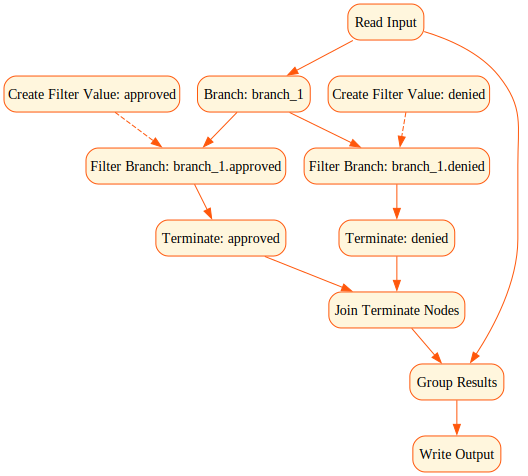

time: 4.26 s (started: 2024-12-22 22:00:27 -03:00)


In [8]:
output_image_path = "dag.svg"

render_pipeline(builder, output_image_path, render_port=21111)

In [9]:
result = run_local(builder)

result.head()

,backfill_id,key,status,input_node
0,test-id,f0369ba55a60b5bc5bc8666a964c395c,DENIED,"{'tax_id': '0', 'score': 81}"
1,test-id,60a146574a1ec5f09a27e1f15ae95ded,APPROVED,"{'tax_id': '1', 'score': 836}"
2,test-id,761f36e599f6ca3cfb859271468973f2,DENIED,"{'tax_id': '2', 'score': 48}"
3,test-id,3254c1565be80b4fe68c057671204ff6,APPROVED,"{'tax_id': '3', 'score': 952}"
4,test-id,0e16afcc463ccb97987fd290aa35dc9d,APPROVED,"{'tax_id': '4', 'score': 650}"


time: 2.99 s (started: 2024-12-22 22:00:31 -03:00)
